In [ ]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.initializers import he_uniform,glorot_uniform,random_normal,random_uniform,glorot_normal,zeros,he_normal
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from prettytable import PrettyTable
import time
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


**Splitting the data into train and test** 

In [ ]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()

In [ ]:
print("number of training samples :",X_train.shape[0],"and each image is of shape (%d,%d)"%(X_train.shape[1],X_train.shape[2]))
print("number of test samples :",X_test.shape[0],"and each image is of shape (%d,%d)"%(X_test.shape[1],X_test.shape[2]))

number of training samples : 60000 and each image is of shape (28,28)
number of test samples : 10000 and each image is of shape (28,28)


In [ ]:
#converting into 784 dimensions
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

#
print("after converting the shapes ")
print("train data shape ",X_train.shape)
print("test data shape ",X_test.shape)

after converting the shapes 
train data shape  (60000, 784)
test data shape  (10000, 784)


**Doing normalization of train and test**

In [ ]:
Counter(X_train[0])
#as all values are between 0-255 we need to normalize the data before applying to MLP

X_train=X_train/255
X_test=X_test/255

In [ ]:
#conversion of output into 10-D vector (one hot encoding)
print("class label of random image : ",y_train[2])
y_train=np_utils.to_categorical(y_train,10)
y_test=np_utils.to_categorical(y_test,10)
print("after conversion class label of random image becomes : ",y_train[2])

class label of random image :  4
after conversion class label of random image becomes :  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


***setting some common parameters for all MLP architectures***

In [ ]:
output_dimensions=10
input_dimensions=X_train.shape[1]

epoch=100
batch_size=100

***plotting weights distribution***

In [ ]:
def plot_wt_disb(model,indices):
  wts1=model.get_weights()
  total_layers=len(indices)
  color=['orange','blue','yellow','olive','pink','skyblue']
  plt.figure(figsize=(14,6))
  
  for i in range(1,total_layers+1):
    plt.subplot(1,total_layers,i)
    sns.violinplot(y=wts1[indices[i-1]].flatten().reshape(-1,1),color=color[i-1])
    if i==total_layers:
      plt.xlabel("output layer")
    else :
      plt.xlabel("hidden lyer "+str(i))
  plt.suptitle("weights distribution for all layers")
  plt.show()


**1. Architecture 1 (784---1024 --256---10): 2 hidden layers+Relu activation+batch normalization+he_uniform weight initialization**

*hyperparameter tuning for 1st architecture*

In [ ]:
def do_hyp_tuning(drop_rate):
  model_test=Sequential()
  model_test.add(Dense(1024,input_shape=(X_train.shape[1],),activation='relu',kernel_initializer=he_uniform()))
  model_test.add(BatchNormalization())
  model_test.add(Dropout(drop_rate))
  
  model_test.add(Dense(250,activation='relu',kernel_initializer=he_uniform()))
  model_test.add(BatchNormalization())
  model_test.add(Dropout(drop_rate))
  
  model_test.add(Dense(output_dimensions,activation='softmax'))
  
  model_test.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
  return model_test

In [ ]:
rates=[i for i in np.arange(0,1,0.2)]
kclf=KerasClassifier(build_fn=do_hyp_tuning,epochs=epoch,batch_size=batch_size,verbose=0)
param_grid=dict(drop_rate=rates)

gd_s=GridSearchCV(estimator=kclf,param_grid=param_grid)
gd_s.fit(X_train,y_train)

In [ ]:
print("best score is {} using best drop rate {}".format(gd_s.best_score_,np.array(gd_s.best_params_.values())))

best score is 0.9768833435575167 using best drop rate dict_values([0.4])


**1.1 Defining the layers in our architecture**

In [ ]:
model1=Sequential()
#defining first layer with weight initialization using 'he_uniform'
model1.add(Dense(1024,input_shape=(input_dimensions,),activation='relu',use_bias=True,kernel_initializer=he_uniform()))
#adding batch normalization after this first layer
model1.add(BatchNormalization())
#adding dropout to first layer
model1.add(Dropout(0.3))

model1.add(Dense(256,activation='relu',kernel_initializer=he_uniform()))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

model1.add(Dense(output_dimensions,activation='softmax',kernel_initializer=he_uniform()))


model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 1024)              803840    
_________________________________________________________________
batch_normalization_51 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_49 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               262400    
_________________________________________________________________
batch_normalization_52 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_50 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 10)                2570      
Total para

**1.2 Compiling and running the model**

In [ ]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history1=model1.fit(X_train,y_train,batch_size=batch_size,epochs=epoch,validation_data=(X_test,y_test),verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 24s 398us/step - loss: 0.2513 - acc: 0.9244 - val_loss: 0.0983 - val_acc: 0.9693
Epoch 2/100
60000/60000 [==============================] - 18s 308us/step - loss: 0.1223 - acc: 0.9619 - val_loss: 0.0809 - val_acc: 0.9750
Epoch 3/100
60000/60000 [==============================] - 18s 307us/step - loss: 0.0917 - acc: 0.9720 - val_loss: 0.0738 - val_acc: 0.9768
Epoch 4/100
60000/60000 [==============================] - 19s 309us/step - loss: 0.0780 - acc: 0.9764 - val_loss: 0.0784 - val_acc: 0.9754
Epoch 5/100
60000/60000 [==============================] - 19s 310us/step - loss: 0.0705 - acc: 0.9770 - val_loss: 0.0701 - val_acc: 0.9775
Epoch 6/100
60000/60000 [==============================] - 18s 307us/step - loss: 0.0620 - acc: 0.9800 - val_loss: 0.0692 - val_acc: 0.9784
Epoch 7/100
60000/60000 [==============================] - 18s 308us/step - loss: 0.0497 - acc: 0.9834 - val_l

test score : 0.09149189763210439
test_accuracy:  0.9844


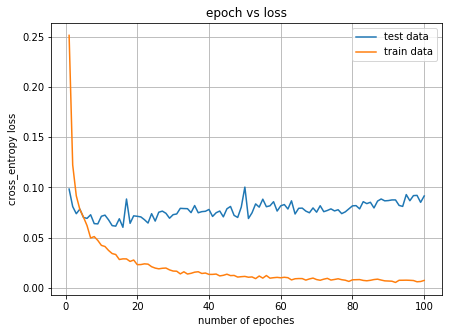

In [ ]:
test_param=model1.evaluate(X_test,y_test,verbose=0)
print("test score :",test_param[0])
print("test_accuracy: ",test_param[1])

plt.figure(figsize=(7,5))
plt.grid()
plt.plot(np.arange(1,epoch+1),history1.history['val_loss'],label="test data")
plt.plot(np.arange(1,epoch+1),history1.history['loss'],label='train data')
plt.title("epoch vs loss")
plt.xlabel("number of epoches")
plt.ylabel("cross_entropy loss")
plt.legend()


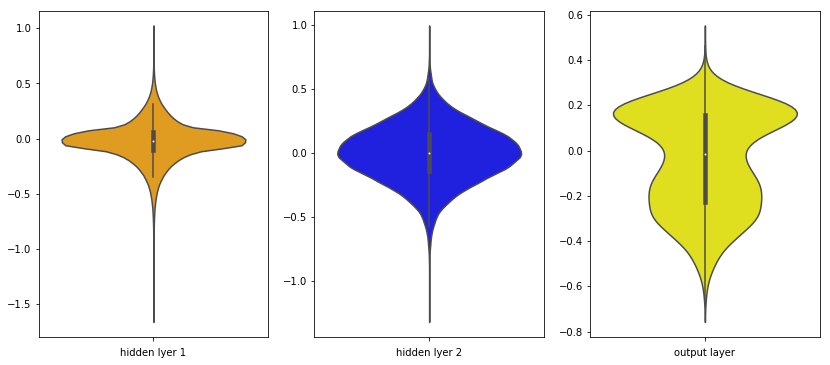

In [ ]:
plot_wt_disb(model1,[0,6,12])

**2. Architecture 2 (784---1024 ---512----128--10): 3 hidden layers+Relu activation+batch normalization+he_uniform weight initialization**

In [ ]:
model2=Sequential()
model2.add(Dense(1024,input_shape=(X_train.shape[1],),activation='relu',use_bias=True,kernel_initializer=he_uniform()))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(512,activation='relu',use_bias=True,kernel_initializer=he_uniform()))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(128,activation='relu',use_bias=True,kernel_initializer=he_uniform()))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(output_dimensions,activation='softmax',kernel_initializer=he_uniform()))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 1024)              803840    
_________________________________________________________________
batch_normalization_53 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_51 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_75 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_54 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_52 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 128)               65664     
__________

In [ ]:
model2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history2=model2.fit(X_train,y_train,batch_size=batch_size,epochs=epoch,validation_data=(X_test,y_test),verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 31s 509us/step - loss: 0.4259 - acc: 0.8720 - val_loss: 0.1269 - val_acc: 0.9614
Epoch 2/100
60000/60000 [==============================] - 25s 413us/step - loss: 0.2000 - acc: 0.9397 - val_loss: 0.0957 - val_acc: 0.9711
Epoch 3/100
60000/60000 [==============================] - 25s 414us/step - loss: 0.1598 - acc: 0.9518 - val_loss: 0.0856 - val_acc: 0.9726
Epoch 4/100
60000/60000 [==============================] - 25s 412us/step - loss: 0.1339 - acc: 0.9594 - val_loss: 0.0774 - val_acc: 0.9762
Epoch 5/100
60000/60000 [==============================] - 25s 412us/step - loss: 0.1185 - acc: 0.9638 - val_loss: 0.0660 - val_acc: 0.9788
Epoch 6/100
60000/60000 [==============================] - 25s 413us/step - loss: 0.1074 - acc: 0.9675 - val_loss: 0.0685 - val_acc: 0.9803
Epoch 7/100
60000/60000 [==============================] - 25s 416us/step - loss: 0.0983 - acc: 0.9700 - val_l

test score : 0.06094194120323909
test_accuracy:  0.987


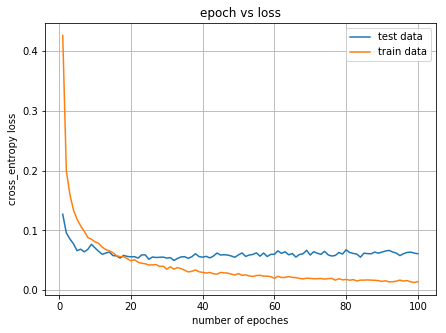

In [ ]:
test_param=model2.evaluate(X_test,y_test,verbose=0)
print("test score :",test_param[0])
print("test_accuracy: ",test_param[1])

plt.figure(figsize=(7,5))
plt.grid()
plt.plot(np.arange(1,epoch+1),history2.history['val_loss'],label="test data")
plt.plot(np.arange(1,epoch+1),history2.history['loss'],label='train data')
plt.title("epoch vs loss")
plt.xlabel("number of epoches")
plt.ylabel("cross_entropy loss")
plt.legend()


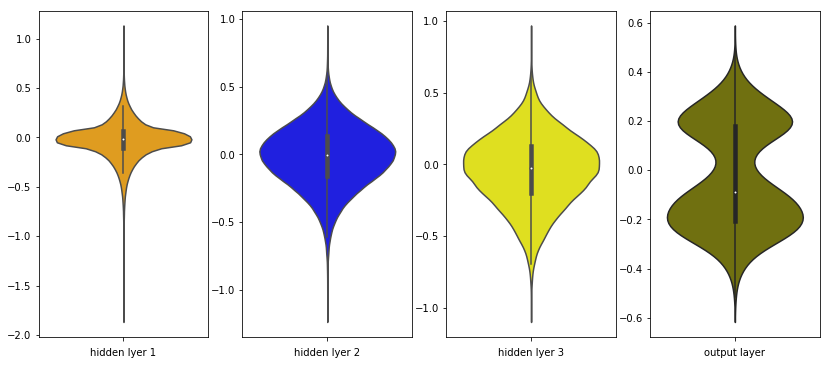

In [ ]:
plot_wt_disb(model2,[0,6,12,18])

**3. Architecture 3 (784---1024 ---256---64----32--16---10): 5 hidden layers+Relu activation+batch normalizatiom+he_uniform_weight initialization**

In [ ]:
model3=Sequential()
model3.add(Dense(1024,input_shape=(X_train.shape[1],),activation='relu',use_bias=True,kernel_initializer=he_uniform()))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(256,activation='relu',use_bias=True,kernel_initializer=he_uniform()))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(64,activation='relu',use_bias=True,kernel_initializer=he_uniform()))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(32,activation='relu',use_bias=True,kernel_initializer=he_uniform()))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(16,activation='relu',use_bias=True,kernel_initializer=he_uniform()))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(output_dimensions,activation='softmax'))

model3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 1024)              803840    
_________________________________________________________________
batch_normalization_56 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_54 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_79 (Dense)             (None, 256)               262400    
_________________________________________________________________
batch_normalization_57 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_55 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 64)                16448     
__________

In [ ]:
model3.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history3=model3.fit(X_train,y_train,batch_size=batch_size,epochs=epoch,validation_data=(X_test,y_test),verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 26s 430us/step - loss: 1.5931 - acc: 0.4522 - val_loss: 0.5116 - val_acc: 0.8839
Epoch 2/100
60000/60000 [==============================] - 19s 320us/step - loss: 0.8747 - acc: 0.7121 - val_loss: 0.2395 - val_acc: 0.9465
Epoch 3/100
60000/60000 [==============================] - 19s 321us/step - loss: 0.6439 - acc: 0.8023 - val_loss: 0.1698 - val_acc: 0.9569
Epoch 4/100
60000/60000 [==============================] - 19s 324us/step - loss: 0.5370 - acc: 0.8411 - val_loss: 0.1610 - val_acc: 0.9582
Epoch 5/100
60000/60000 [==============================] - 19s 321us/step - loss: 0.4724 - acc: 0.8629 - val_loss: 0.1431 - val_acc: 0.9653
Epoch 6/100
60000/60000 [==============================] - 19s 320us/step - loss: 0.4368 - acc: 0.8778 - val_loss: 0.1233 - val_acc: 0.9699
Epoch 7/100
60000/60000 [==============================] - 19s 320us/step - loss: 0.4033 - acc: 0.8868 - val_l

test score : 0.10134605020897107
test_accuracy:  0.9857


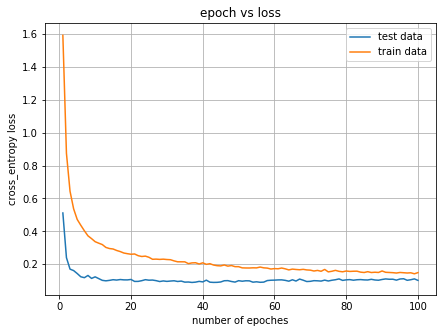

In [ ]:
test_param=model3.evaluate(X_test,y_test,verbose=0)
print("test score :",test_param[0])
print("test_accuracy: ",test_param[1])

plt.figure(figsize=(7,5))
plt.grid()
plt.plot(np.arange(1,epoch+1),history3.history['val_loss'],label="test data")
plt.plot(np.arange(1,epoch+1),history3.history['loss'],label='train data')
plt.title("epoch vs loss")
plt.xlabel("number of epoches")
plt.ylabel("cross_entropy loss")
plt.legend()

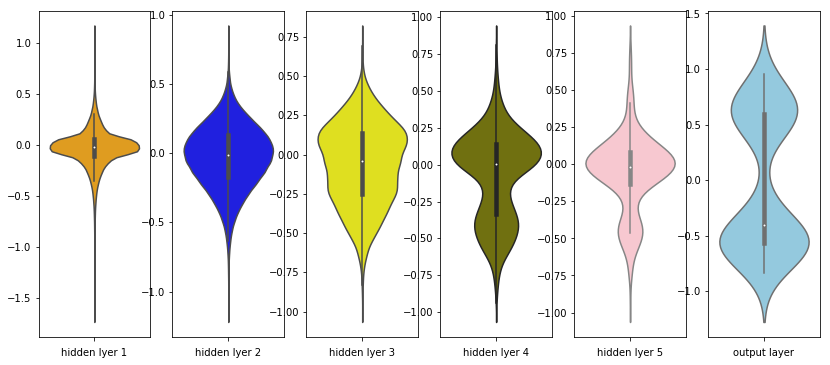

In [ ]:
plot_wt_disb(model3,[0,6,12,18,24,30])



---






# Creating general architectures of MLP to analyze the results

---



In [ ]:
def loss_curve(model,history):
  test_param=model.evaluate(X_test,y_test,verbose=0)
  print("test score :",test_param[0])
  print("test_accuracy: ",test_param[1])
  
  
  plt.figure(figsize=(9,5))
  plt.grid()
  plt.plot(np.arange(1,epoch+1),history.history['val_loss'],label="test data")
  plt.plot(np.arange(1,epoch+1),history.history['loss'],label='train data')
  plt.title("epoch vs loss")
  plt.xlabel("number of epoches")
  plt.ylabel("cross_entropy loss")
  plt.legend()
  
  

## **5.Creating 2 hidden layer architecture with varying parameters**

In [ ]:
def architecture1(neurons1,neurons2,activation,bn_enabled,dropout_rate,optimizer,weight_initialization):
  
  architecture=str(neurons1)+"--"+str(neurons2)
  
  #used to keep track of the edge weights
  indices_of_weights=[]
  
  model=Sequential()
  
  model.add(Dense(neurons1,input_shape=(X_train.shape[1],),activation=activation,kernel_initializer=weight_initialization[0]))
  indices_of_weights.append(0)
  
  ind=1
  if bn_enabled[0]:
    model.add(BatchNormalization())
    indices_of_weights.append(6)
    
  else:
    indices_of_weights.append(2)
    
  model.add(Dropout(dropout_rate))
  
  ind+=1
  
  model.add(Dense(neurons2,activation=activation,kernel_initializer=weight_initialization[0]))
  if bn_enabled[1]:
    model.add(BatchNormalization())
    indices_of_weights.append(indices_of_weights[ind-1]+6)
  else:
    indices_of_weights.append(indices_of_weights[ind-1]+2)
  model.add(Dropout(dropout_rate))
  
  model.add(Dense(output_dimensions,activation='softmax',kernel_initializer=weight_initialization[0]))
  

  
  model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
  history=model.fit(X_train,y_train,batch_size=batch_size,epochs=epoch,validation_data=(X_test,y_test),verbose=0)
  
  
  loss_curve(model,history)
  
  print("-"*150)
  
  
  plot_wt_disb(model,indices_of_weights)
  
    
  
  train_score=model.evaluate(X_train,y_train,verbose=0)[0]
  test_score=model.evaluate(X_test,y_test,verbose=0)[0]
  
  pt=PrettyTable()
  pt.field_names=["Architecture","activation","weight_init","BN Used?","dropout_rate","optimizer","train_logloss","test_logloss"]
  pt.add_row([architecture,activation,weight_initialization[1],bn_enabled,dropout_rate,optimizer,train_score,test_score])
  
   
  return pt

## **6.Creating 3 hidden layer architecture with varying parameters**

In [ ]:
def architecture2(neurons1,neurons2,neurons3,activation,bn_enabled,dropout_rate,optimizer,weight_initialization):
  
  architecture=str(neurons1)+"--"+str(neurons2)+"--"+str(neurons3)
  
  model=Sequential()
  
  #used to keep track of the edge weights
  indices_of_weights=[]
  
  model.add(Dense(neurons1,input_shape=(X_train.shape[1],),activation=activation,kernel_initializer=weight_initialization[0]))
  indices_of_weights.append(0)
  
  
  ind=1
  if bn_enabled[0]:
    model.add(BatchNormalization())
    indices_of_weights.append(indices_of_weights[ind-1]+6)
  else:
    indices_of_weights.append(indices_of_weights[ind-1]+2)
  model.add(Dropout(dropout_rate))
  
  ind+=1
  model.add(Dense(neurons2,activation=activation,kernel_initializer=weight_initialization[0]))
  if bn_enabled[1]:
    model.add(BatchNormalization())
    indices_of_weights.append(indices_of_weights[ind-1]+6)
  else:
    indices_of_weights.append(indices_of_weights[ind-1]+2)
  model.add(Dropout(dropout_rate))
  
  ind+=1
  model.add(Dense(neurons3,activation=activation,kernel_initializer=weight_initialization[0]))
  if bn_enabled[2]:
    model.add(BatchNormalization())
    indices_of_weights.append(indices_of_weights[ind-1]+6)
  else:
    indices_of_weights.append(indices_of_weights[ind-1]+2)
  model.add(Dropout(dropout_rate))
  
  model.add(Dense(output_dimensions,activation='softmax',kernel_initializer=weight_initialization[0]))
 
  
  model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
  history=model.fit(X_train,y_train,batch_size=batch_size,epochs=epoch,validation_data=(X_test,y_test),verbose=0)
  
  
  loss_curve(model,history)
  
  print("-"*150)
  
  
  plot_wt_disb(model,indices_of_weights)
  
  
  
  train_score=model.evaluate(X_train,y_train,verbose=0)[0]
  test_score=model.evaluate(X_test,y_test,verbose=0)[0]
  
  pt=PrettyTable()
  pt.field_names=["Architecture","activation","weight_init","BN Used?","dropout_rate","optimizer","train_logloss","test_logloss"]
  pt.add_row([architecture,activation,weight_initialization[1],bn_enabled,dropout_rate,optimizer,train_score,test_score])
  
  
  return pt

## **7.Creating 5 hidden layer architecture with varying parameters**

In [ ]:
def architecture3(neurons1,neurons2,neurons3,neurons4,neurons5,activation,bn_enabled,dropout_rate,optimizer,weight_initialization):
  
  layer_5=[neurons1,neurons2,neurons3,neurons4,neurons5]
  architecture=str(neurons1)+"--"+str(neurons2)+"--"+str(neurons3)+"--"+str(neurons4)+"--"+str(neurons5)
  
  model=Sequential()
  indices_of_weights=[]
  
  #initial hidden layer
  model.add(Dense(layer_5[0],input_shape=(X_train.shape[1],),activation=activation,kernel_initializer=weight_initialization[0]))
  indices_of_weights.append(0)
  
  ind=1
  if bn_enabled[0]:
    model.add(BatchNormalization())
    indices_of_weights.append(indices_of_weights[ind-1]+6)
  else:
    indices_of_weights.append(indices_of_weights[ind-1]+2)
  model.add(Dropout(dropout_rate))
  
  #4 hidden layers after first hidden layer
  for i in range(1,len(layer_5)):
    ind+=1
    model.add(Dense(layer_5[i],activation=activation,kernel_initializer=weight_initialization[0]))
    if bn_enabled[ind-1]:
      model.add(BatchNormalization())
      indices_of_weights.append(indices_of_weights[ind-1]+6)
    else:
      indices_of_weights.append(indices_of_weights[ind-1]+2)
    model.add(Dropout(dropout_rate))
  
 
  #output layer
  model.add(Dense(output_dimensions,activation='softmax',kernel_initializer=weight_initialization[0]))
  

  
  model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
  history=model.fit(X_train,y_train,batch_size=batch_size,epochs=epoch,validation_data=(X_test,y_test),verbose=0)
  
  
  loss_curve(model,history)
  
  print("-"*150)
  
  plot_wt_disb(model,indices_of_weights)
    
  
  train_score=model.evaluate(X_train,y_train,verbose=0)[0]
  test_score=model.evaluate(X_test,y_test,verbose=0)[0]
  
  pt=PrettyTable()
  pt.field_names=["Architecture","activation","weight_init","BN Used?","dropout_rate","optimizer","train_logloss","test_logloss"]
  pt.add_row([architecture,activation,weight_initialization[1],bn_enabled,dropout_rate,optimizer,train_score,test_score])
  
  
  return pt

## **8.Observing our MLP on different parameters**

**8.1 On different activation functions**

test score : 0.0828125310616324
test_accuracy:  0.9815
------------------------------------------------------------------------------------------------------------------------------------------------------


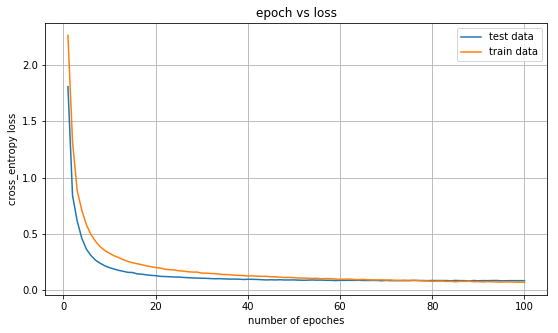

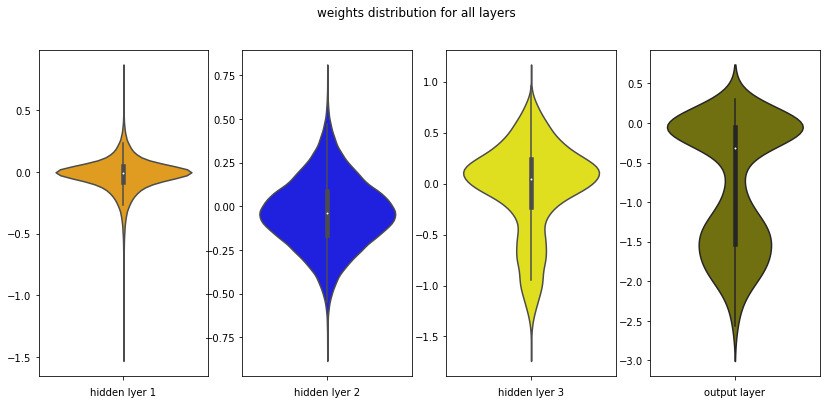

In [ ]:
#applying sigmoid activation
wrap_ac1=architecture2(512,128,64,'sigmoid',[False]*5,0.5,'Adadelta',(random_normal(),'random_normal'))

test score : 0.08037588896080851
test_accuracy:  0.9832
------------------------------------------------------------------------------------------------------------------------------------------------------


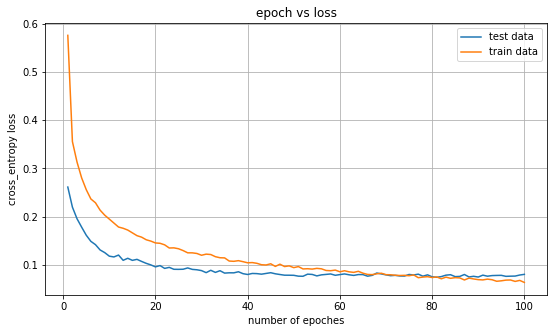

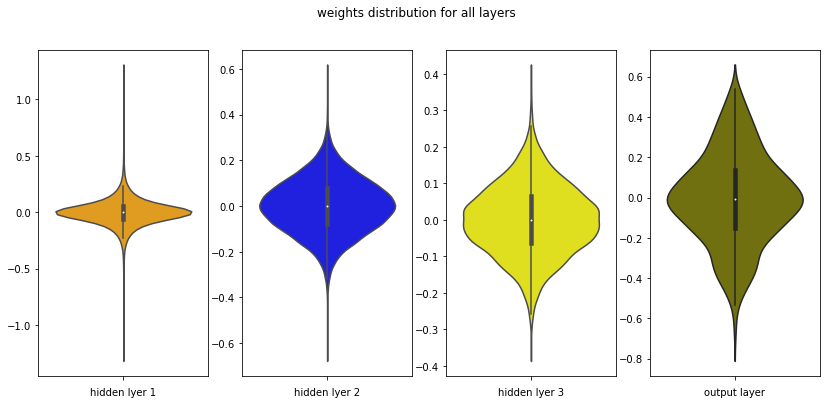

In [ ]:
#applying tanh activation
wrap_ac2=architecture2(512,128,64,'tanh',[False]*5,0.5,'Adadelta',(random_normal(),'random_normal'))

test score : 0.11101299412349054
test_accuracy:  0.984
------------------------------------------------------------------------------------------------------------------------------------------------------


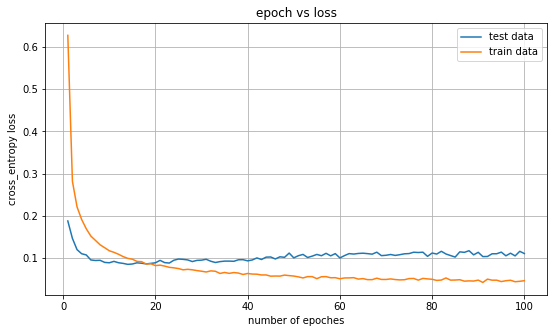

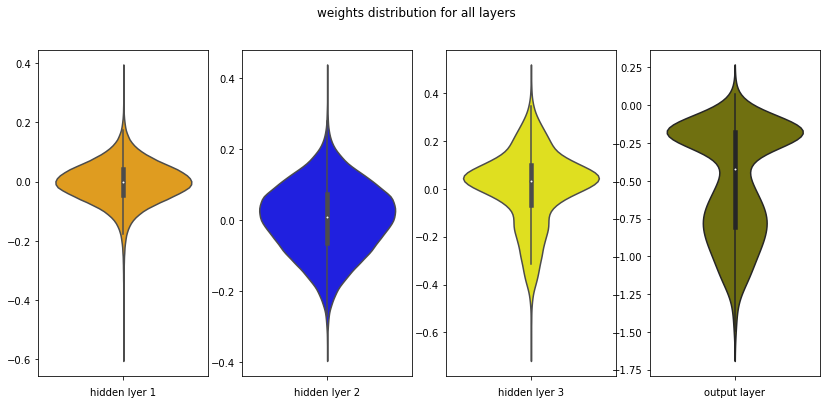

In [ ]:
#applying relu activation
wrap_ac3=architecture2(512,128,64,'relu',[False]*5,0.5,'Adadelta',(random_normal(),'random_normal'))

In [ ]:
print("For relu activation")
print(wrap_ac3)

print("\n")
print("For sigmoid activation")
print(wrap_ac1)

For relu activation
+--------------+------------+---------------+-------------------------------------+--------------+-----------+----------------------+---------------------+
| Architecture | activation |  weight_init  |               BN Used?              | dropout_rate | optimizer |    train_logloss     |     test_logloss    |
+--------------+------------+---------------+-------------------------------------+--------------+-----------+----------------------+---------------------+
| 512--128--64 |    relu    | random_normal | [False, False, False, False, False] |     0.5      |  Adadelta | 0.004064682896623541 | 0.11101299412349054 |
+--------------+------------+---------------+-------------------------------------+--------------+-----------+----------------------+---------------------+


For sigmoid activation
+--------------+------------+---------------+-------------------------------------+--------------+-----------+---------------------+--------------------+
| Architecture | acti

**CONCLUSIONS**

*    Relu and sigmoid provides the almost similar results.
* Relu typically converge to optimum faster as compared to sigmoid this may be due to vanishing gradient.











---



**8.2 On Different weight initialization**

test score : 2.3010748847961424
test_accuracy:  0.1135
------------------------------------------------------------------------------------------------------------------------------------------------------


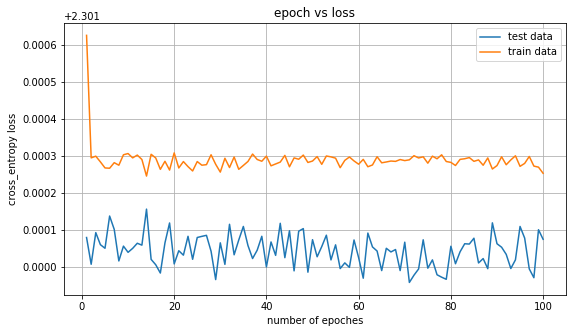

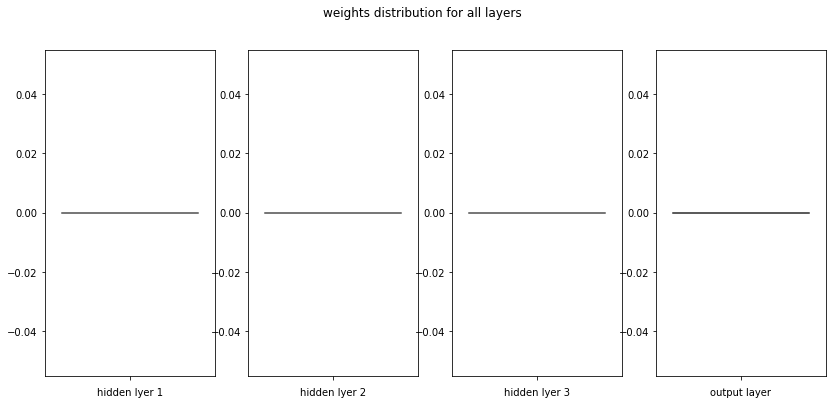

In [ ]:
#from here on we will apply relu on all kind of activations.
#Random normal initialization is just done above.
#0's initialization of weights.
wrap_wt1=architecture2(512,128,64,'relu',[False]*5,0.5,'Adadelta',(zeros(),'zero initialized'))

test score : 0.12793548600541516
test_accuracy:  0.9818
------------------------------------------------------------------------------------------------------------------------------------------------------


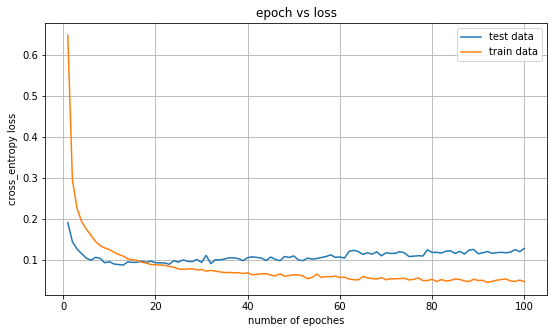

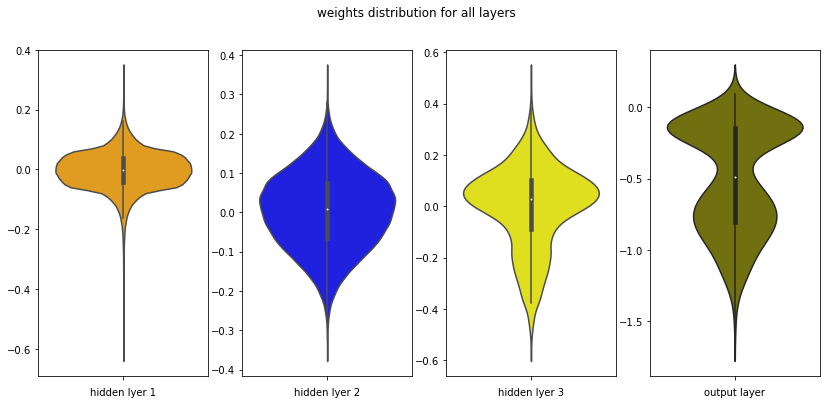

In [ ]:
#random normal has been checked previously
#checking for glorot uniform
wrap_wt2=architecture2(512,128,64,'relu',[False]*5,0.5,'Adadelta',(glorot_uniform(),'glorot_uniform'))

test score : 0.1151257909282579
test_accuracy:  0.9838
------------------------------------------------------------------------------------------------------------------------------------------------------


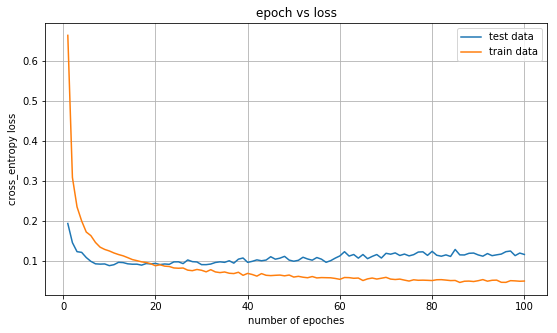

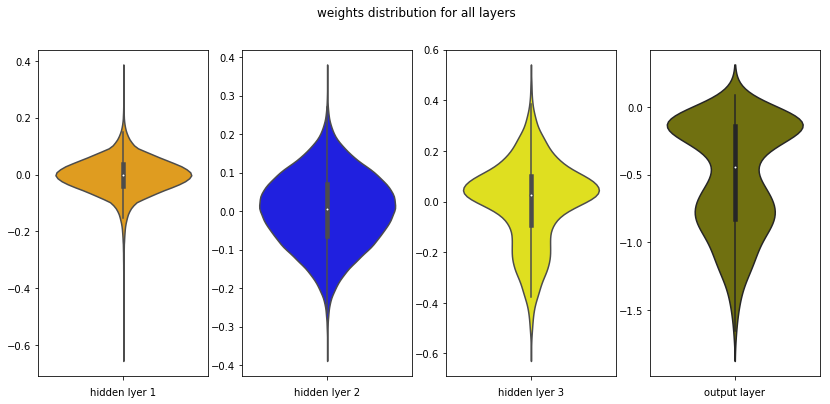

In [ ]:
#checking for glorot normal
wrap_wt3=architecture2(512,128,64,'relu',[False]*5,0.5,'Adadelta',(glorot_normal(),'glorot_normal'))

test score : 0.12545807117758695
test_accuracy:  0.9844
------------------------------------------------------------------------------------------------------------------------------------------------------


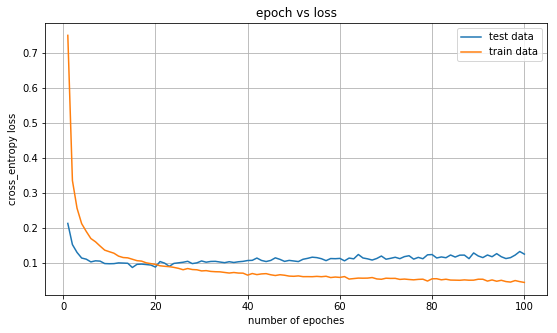

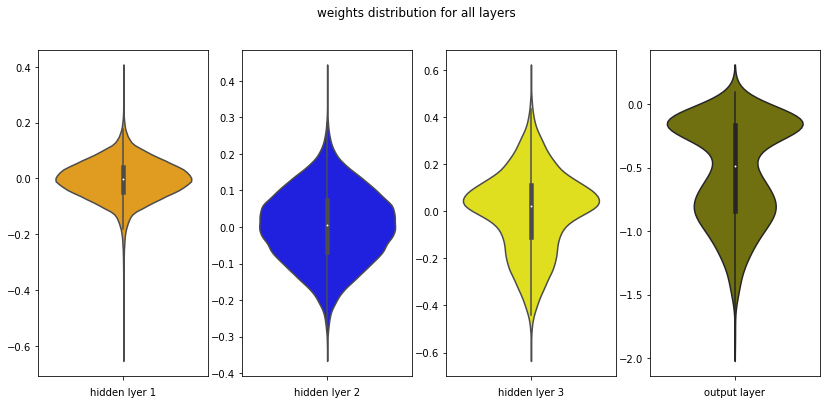

In [ ]:
#checking for glorot normal
wrap_wt4=architecture2(512,128,64,'relu',[False]*5,0.5,'Adadelta',(he_normal(),'he_normal'))

test score : 0.12065555130048655
test_accuracy:  0.984
------------------------------------------------------------------------------------------------------------------------------------------------------


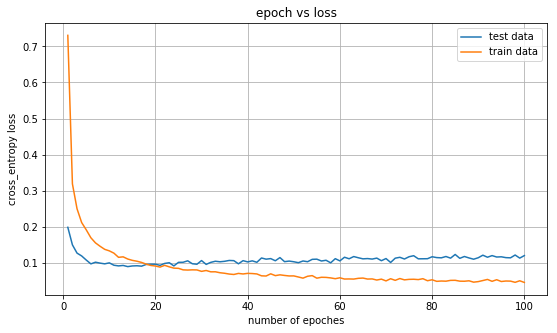

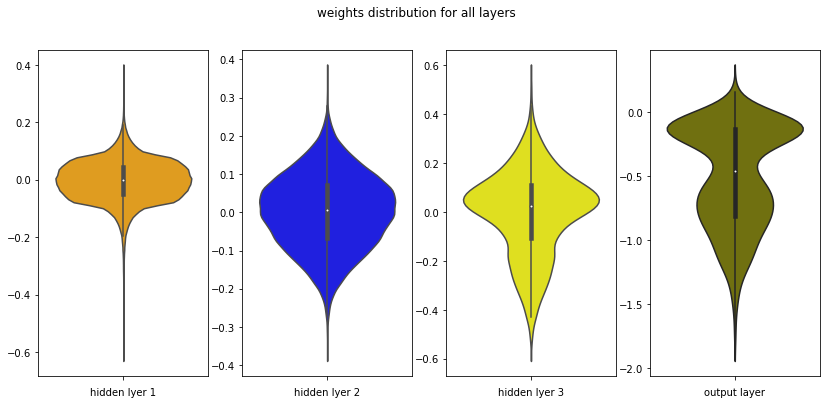

In [ ]:
#checking for glorot normal
wrap_wt5=architecture2(512,128,64,'relu',[False]*5,0.5,'Adadelta',(he_uniform(),'he_uniform'))

**CONCLUSIONS**


*   initializing all weights by zero gives miserable results we should avoid it.
*   Using random_normal(),glorot_uniform(),glorot_normal(),he_normal(),he_uniform() the performance as well as weight distributions that we get after training our MLP's are almost same; we can use any of the initializers.





---



**8.3 Affect Of Applying Batch Normalization**

test score : 0.4569192543745041
test_accuracy:  0.8692
------------------------------------------------------------------------------------------------------------------------------------------------------


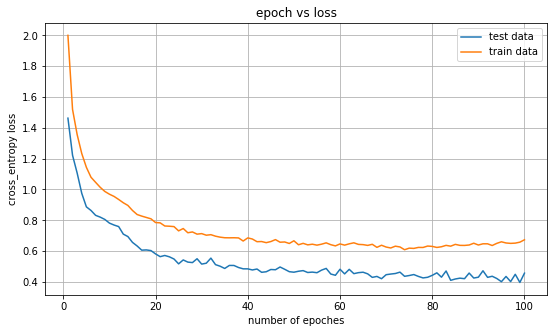

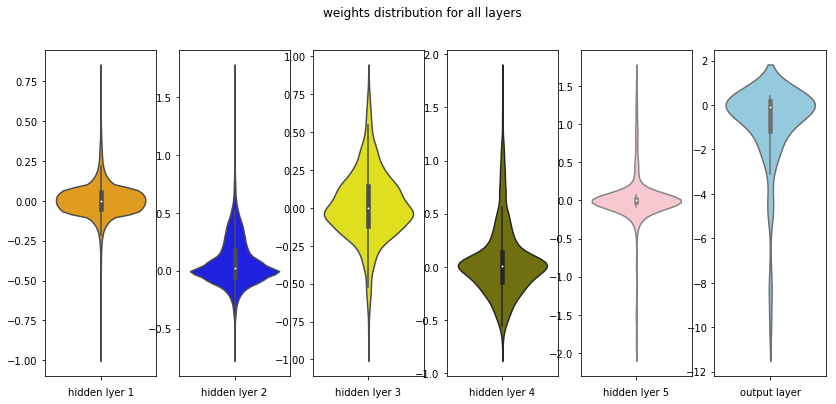

In [ ]:
#after here all activations='relu' and initializer=he_uniform()
#checking for deeper layers 
#NOWHERE APPLYING BATCH NNORMALIZATION
wrap_bn1=architecture3(512,128,64,32,16,'relu',[False]*5,0.5,'Adadelta',(he_uniform(),'he_uniform'))

test score : 0.1005409506703516
test_accuracy:  0.9858
------------------------------------------------------------------------------------------------------------------------------------------------------


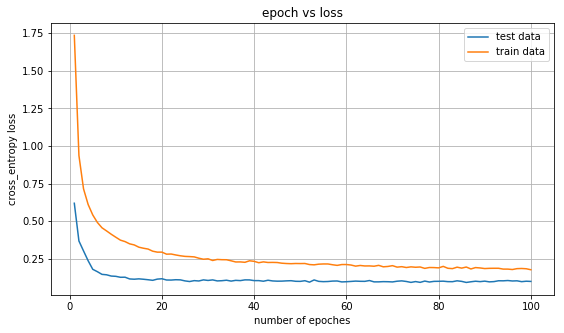

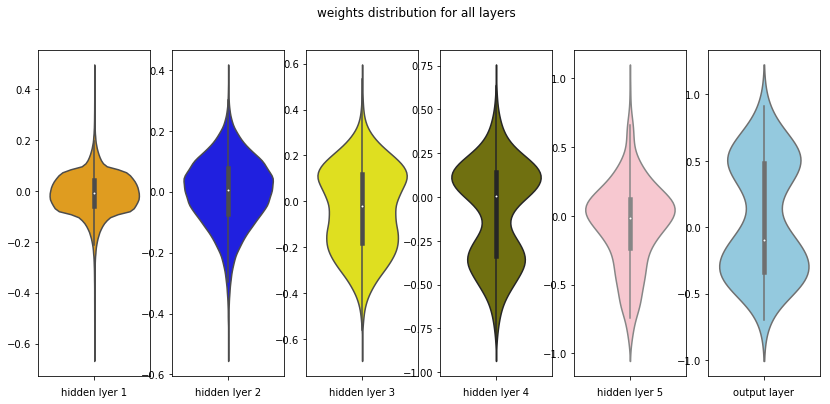

In [ ]:
#Applying normalization at the output of all hidden layers
wrap_bn2=architecture3(512,128,64,32,16,'relu',[True]*5,0.5,'Adadelta',(he_uniform(),'he_uniform'))

test score : 0.14228527568476274
test_accuracy:  0.9803
------------------------------------------------------------------------------------------------------------------------------------------------------


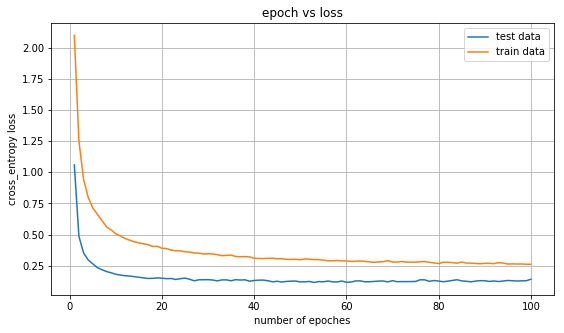

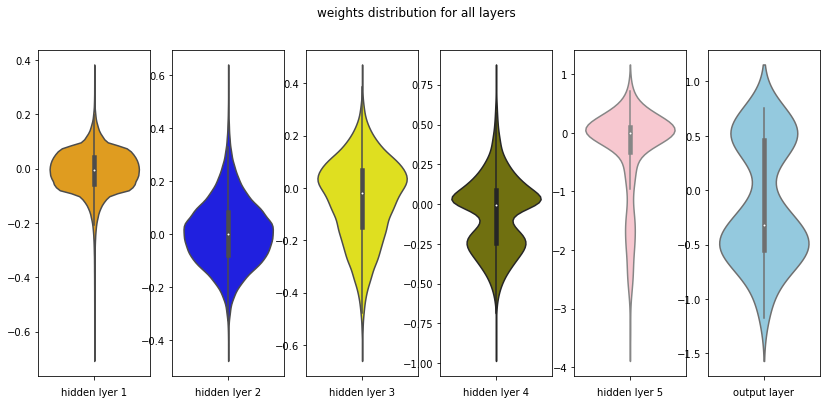

In [ ]:
#Applying normalization in between
wrap_bn3=architecture3(512,128,64,32,16,'relu',[False,True,False,False,True],0.5,'Adadelta',(he_uniform(),'he_uniform'))

**CONCLUSION**


*   For Deeper Layer to avoid internal covariance shift the normalization layer has to be added in between.As we can see that by using batch normalization layer in between the test log-loss has reduced significantly(from 0.33 to 0.10).






---




**8.4 using different optimizers**

test score : 0.10008854026673361
test_accuracy:  0.9794
------------------------------------------------------------------------------------------------------------------------------------------------------


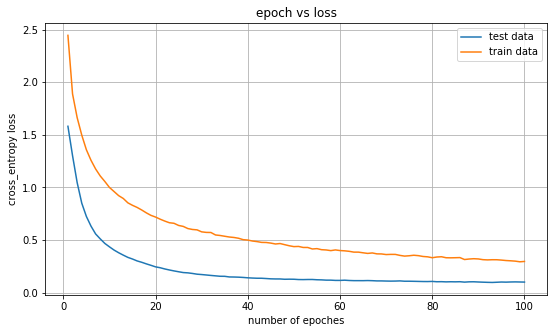

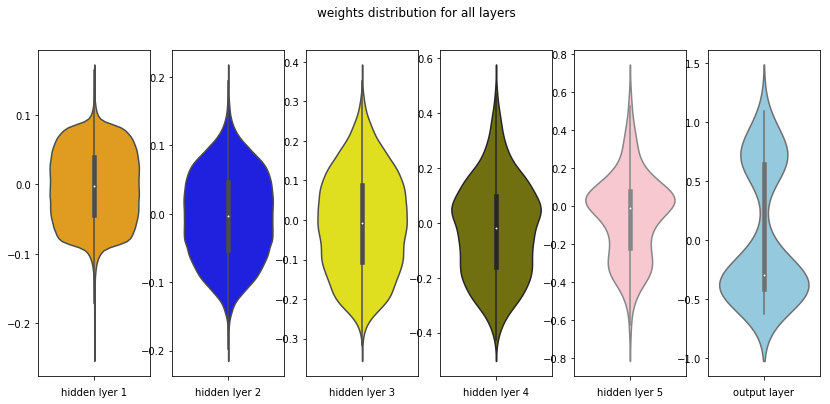

In [ ]:
#SGD
wrap_op1=architecture3(512,128,64,32,16,'relu',[True]*5,0.5,'SGD',(he_uniform(),'he_uniform'))

test score : 0.09291673101950437
test_accuracy:  0.9833
------------------------------------------------------------------------------------------------------------------------------------------------------


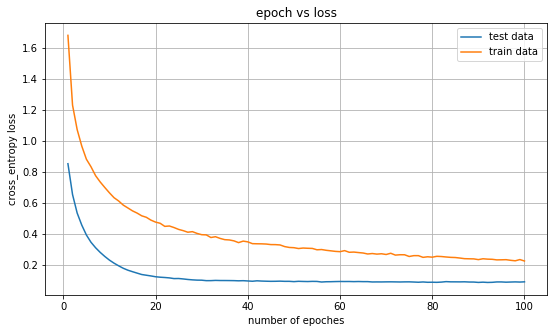

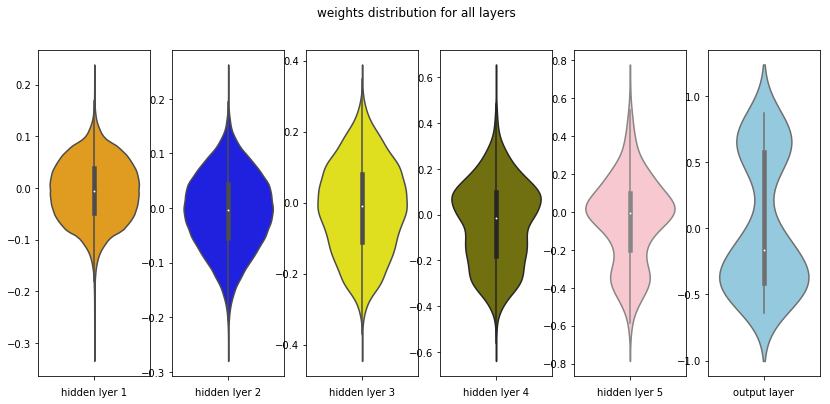

In [ ]:
#Adagrad
wrap_op2=architecture3(512,128,64,32,16,'relu',[True]*5,0.5,'Adagrad',(he_uniform(),'he_uniform'))

test score : 0.09342973879102393
test_accuracy:  0.9861
------------------------------------------------------------------------------------------------------------------------------------------------------


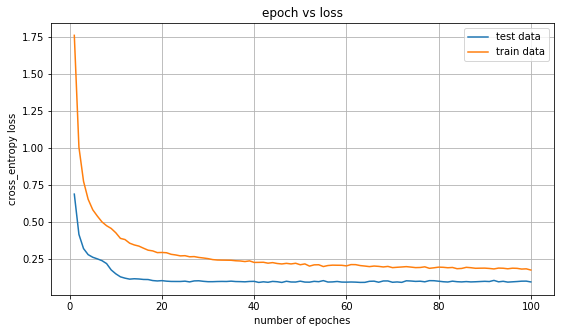

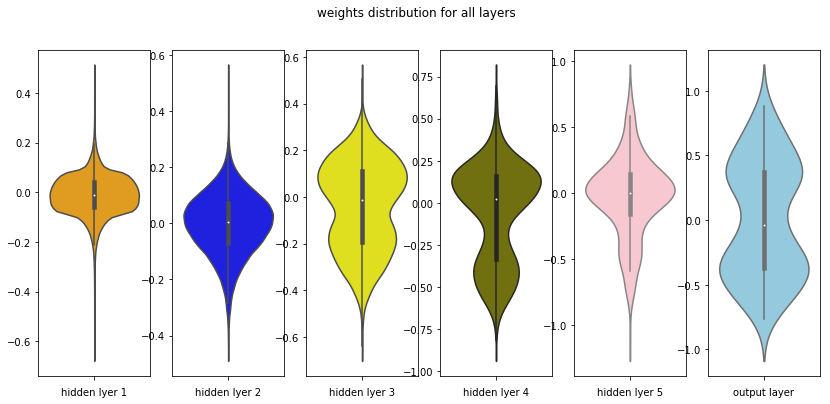

In [ ]:
#Adadelta
wrap_op3=architecture3(512,128,64,32,16,'relu',[True]*5,0.5,'Adadelta',(he_uniform(),'he_uniform'))

test score : 0.09027776421541713
test_accuracy:  0.987
------------------------------------------------------------------------------------------------------------------------------------------------------


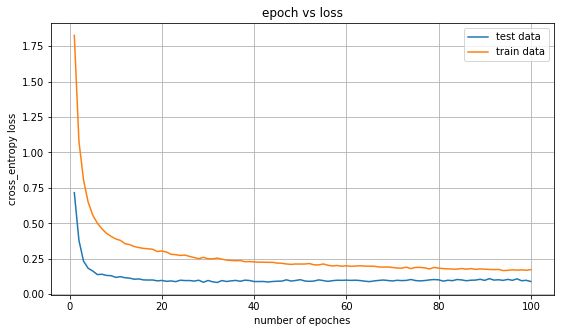

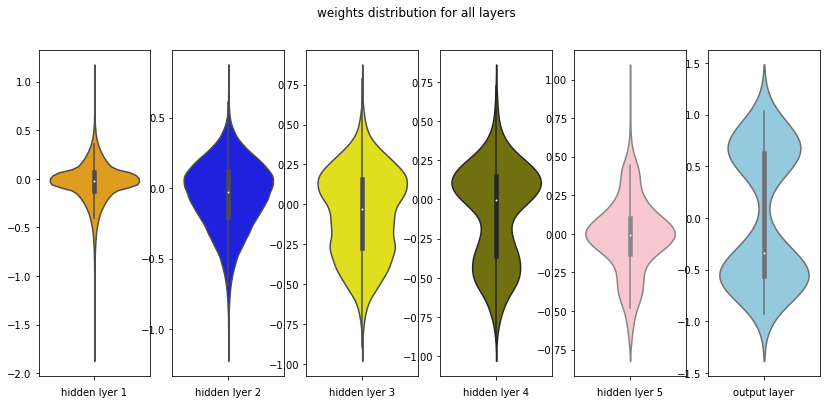

In [ ]:
#Adam
wrap_op4=architecture3(512,128,64,32,16,'relu',[True]*5,0.5,'Adam',(he_uniform(),'he_uniform'))

### CONCLUSIONS


*   As SGD  curve slope is somehow less, to reach to the optimum due to fixed learning rate and no momentum methods available to converge faster.
*   Adagrad also seen to be converge slow this is due to the large alphas (alpha_t=sum(gi^2)) which in turn makes the learning rate slow.

*   Adam and Adadelta converges fast due to the exponential decay average that we considered for the estimation of alphas ;which in turn keeps the learning rate flexible. (we can see that curve is falling fast)








---



**8.6 Affect Of Architectures**

**8.6.1 keeping The number of layers same and checking for number of neurons**

test score : 1.4720323068618775
test_accuracy:  0.4464
------------------------------------------------------------------------------------------------------------------------------------------------------


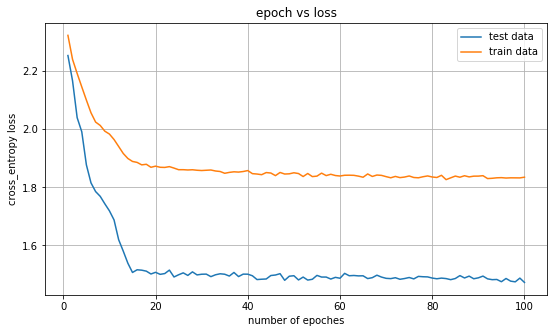

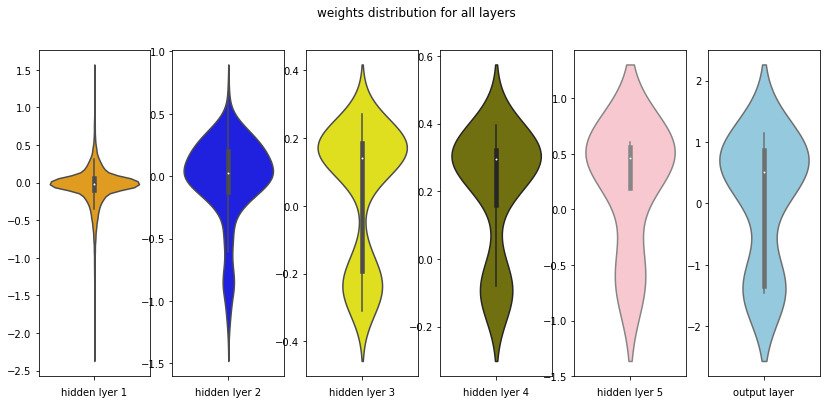

In [ ]:
#trying different number of neurons in architecture 3
#architecture3 where there is more number of activation units is executed just above cell we will compare our model with that
#sparse architecture
wrap_nu1=architecture3(32,16,8,4,2,'relu',[True]*5,0.5,'Adam',(glorot_uniform(),'glorot_uniform'))

### CONCLUSIONS


*   keep the number of activation function quite reasonably high as we can observe for the 5 HL architecture (512,128,64,32,16) we got a log-loss of 0.109 whereas for  5HL architecture (32,16,8,4,2)with all other parameters being same we get a log-loss of 1.41.
* by using more number of neurons the MLP is overfittig as we can clearly see the difference in log loss of train and test data (0.009 and 0.109)



---





**8.6.2 variations on the number of hidden layers**

### CONCLUSION


*   refering to section 1.,2.,3. that are performed at starting in this assignment. 
*   As we Add significantly more number of hidden layers to our MLP it gives us stable results in term of log-loss of train and test data both are almost same.
*   we can see from the epoch vs loss graph for each of 3 architectures.


---



##CONCLUSIONS:

In [ ]:
print("effect of the number of activation units in same depth\n")
print("summary for 5Hl architecture with (512,128,64,32,16)")
print(wrap_op4)
print("\n\n")
print("summary for 5HL architecture with (32,16,8,4,2)")
print(wrap_nu1)

effect of the number of activation units in same depth

summary for 5Hl architecture with (512,128,64,32,16)
+----------------------+------------+-------------+--------------------------------+--------------+-----------+----------------------+---------------------+
|     Architecture     | activation | weight_init |            BN Used?            | dropout_rate | optimizer |    train_logloss     |     test_logloss    |
+----------------------+------------+-------------+--------------------------------+--------------+-----------+----------------------+---------------------+
| 512--128--64--32--16 |    relu    |  he_uniform | [True, True, True, True, True] |     0.5      |    Adam   | 0.009545215994842753 | 0.09027776421541713 |
+----------------------+------------+-------------+--------------------------------+--------------+-----------+----------------------+---------------------+



summary for 5HL architecture with (32,16,8,4,2)
+-----------------+------------+----------------+------

In [ ]:
print("effect of weight initialization:\n")
print("all weight initialized with 0's")
print(wrap_wt1)
print("\n\n")
print("using random normal")
print(wrap_ac3)
print("\n\n")
print("using glorot uniform")
print(wrap_wt2)
print("\n\n")
print("using glorot normal")
print(wrap_wt3)
print("\n\n")
print("using he_normal")
print(wrap_wt4)
print("\n\n")
print("using  he_uniform")
print(wrap_wt5)

effect of weight initialization:

all weight initialized with 0's
+--------------+------------+------------------+-------------------------------------+--------------+-----------+-------------------+--------------------+
| Architecture | activation |   weight_init    |               BN Used?              | dropout_rate | optimizer |   train_logloss   |    test_logloss    |
+--------------+------------+------------------+-------------------------------------+--------------+-----------+-------------------+--------------------+
| 512--128--64 |    relu    | zero initialized | [False, False, False, False, False] |     0.5      |  Adadelta | 2.301206158320109 | 2.3010748847961424 |
+--------------+------------+------------------+-------------------------------------+--------------+-----------+-------------------+--------------------+



using random normal
+--------------+------------+---------------+-------------------------------------+--------------+-----------+----------------------+---

In [ ]:
print("effect of the Batch Normalization on a 5 hidden layer MLP\n")
print("nowhere applying batch normalization")
print(wrap_bn1)
print("\n\n")
print("everywhere applying batch normalization")
print(wrap_bn2)
print("\n\n")
print("applying batch normalization in some layers")
print(wrap_bn2)

effect of the Batch Normalization on a 5 hidden layer MLP

nowhere applying batch normalization
+----------------------+------------+-------------+-------------------------------------+--------------+-----------+---------------------+--------------------+
|     Architecture     | activation | weight_init |               BN Used?              | dropout_rate | optimizer |    train_logloss    |    test_logloss    |
+----------------------+------------+-------------+-------------------------------------+--------------+-----------+---------------------+--------------------+
| 512--128--64--32--16 |    relu    |  he_uniform | [False, False, False, False, False] |     0.5      |  Adadelta | 0.33409038120309514 | 0.4569192543745041 |
+----------------------+------------+-------------+-------------------------------------+--------------+-----------+---------------------+--------------------+



everywhere applying batch normalization
+----------------------+------------+-------------+----------

In [ ]:
print("effect of optimizers used:\n")
print("SGD")
print(wrap_op1)
print("\n\n")
print("Adagrad")
print(wrap_op2)
print("\n\n")
print("Adadelta")
print(wrap_op3)
print("\n\n")
print("Adam")
print(wrap_op4)

effect of optimizers used:

SGD
+----------------------+------------+-------------+--------------------------------+--------------+-----------+---------------------+---------------------+
|     Architecture     | activation | weight_init |            BN Used?            | dropout_rate | optimizer |    train_logloss    |     test_logloss    |
+----------------------+------------+-------------+--------------------------------+--------------+-----------+---------------------+---------------------+
| 512--128--64--32--16 |    relu    |  he_uniform | [True, True, True, True, True] |     0.5      |    SGD    | 0.04114484282826694 | 0.10008854026673361 |
+----------------------+------------+-------------+--------------------------------+--------------+-----------+---------------------+---------------------+



Adagrad
+----------------------+------------+-------------+--------------------------------+--------------+-----------+----------------------+---------------------+
|     Architecture  